## Customer Segmentation RFM

## **Content:**
"Thistransnational data seth contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail .The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers For more: https://www.kaggle.com/datasets/carrie1/ecommerce-data"

Customer Segmentation using RFM (Recency, Frequency, Monetary) is a method used to identify and categorize customers based on their purchasing behavior, allowing businesses to tailor marketing strategies effectively. Recency measures how recently a customer made a purchase, Frequency evaluates how often they purchase, and Monetary assesses the total spending of a customer. By analyzing these three dimensions, businesses can segment customers into distinct groups, such as loyal customers, big spenders, or at-risk customers. This segmentation helps in understanding the value of different customer groups, predicting future behaviors, and creating targeted marketing campaigns to enhance customer retention and maximize revenue.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [3]:
# Reading the CSV file with 'latin1' encoding
df = pd.read_csv('Data/data.csv', encoding='latin1')

# Displaying the last few rows of the DataFrame
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Data Cleaning

In [5]:
copied_df = df.copy()

In [6]:
copied_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df2 = copied_df.dropna()


In [8]:
df2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
# Filter rows containing any NaN values
rows_with_nan = df2[df2.isna().any(axis=1)]

print("Rows containing NaN values:")
print(rows_with_nan)

Rows containing NaN values:
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [10]:
df2.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [12]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [13]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

In [14]:
# Convert 'CustomerID' column to string
df2['CustomerID'] = df2['CustomerID'].astype(str)

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [16]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice
count,406829.000000,406829,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-31 11:48:00,1.950000
75%,12.000000,2011-10-20 13:06:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,248.693370,NaN,69.315162


In [17]:
# Extract rows where 'quantity' column values are less than -1
extracted_rows = df2[df2['Quantity'] < -1]

# Drop those rows from the main DataFrame
df2 = df2[df2['Quantity'] > -1]

print("Extracted rows:")
print(extracted_rows)

print("\nUpdated DataFrame:")
print(df2)

Extracted rows:
       InvoiceNo StockCode                        Description  Quantity  \
235      C536391     22556     PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984   PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983   PACK OF 12 BLUE PAISLEY TISSUES        -24   
238      C536391     21980  PACK OF 12 RED RETROSPOT TISSUES        -24   
239      C536391     21484        CHICK GREY HOT WATER BOTTLE       -12   
...          ...       ...                                ...       ...   
540422   C581484     23843        PAPER CRAFT , LITTLE BIRDIE    -80995   
540448   C581490     22178    VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144    ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258         VICTORIAN SEWING BOX LARGE        -5   
541717   C581569     20979      36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice CustomerID         Country  
235    2010-12-0

In [18]:
df2.describe()

,Quantity,InvoiceDate,UnitPrice
count,397924.000000,397924,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174
min,1.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 14:39:00,1.950000
75%,12.000000,2011-10-20 14:33:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.420210,NaN,22.096788


In [19]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Visualization

In [20]:
# Extract numerical columns
numerical_columns = df2.select_dtypes(include=['number'])

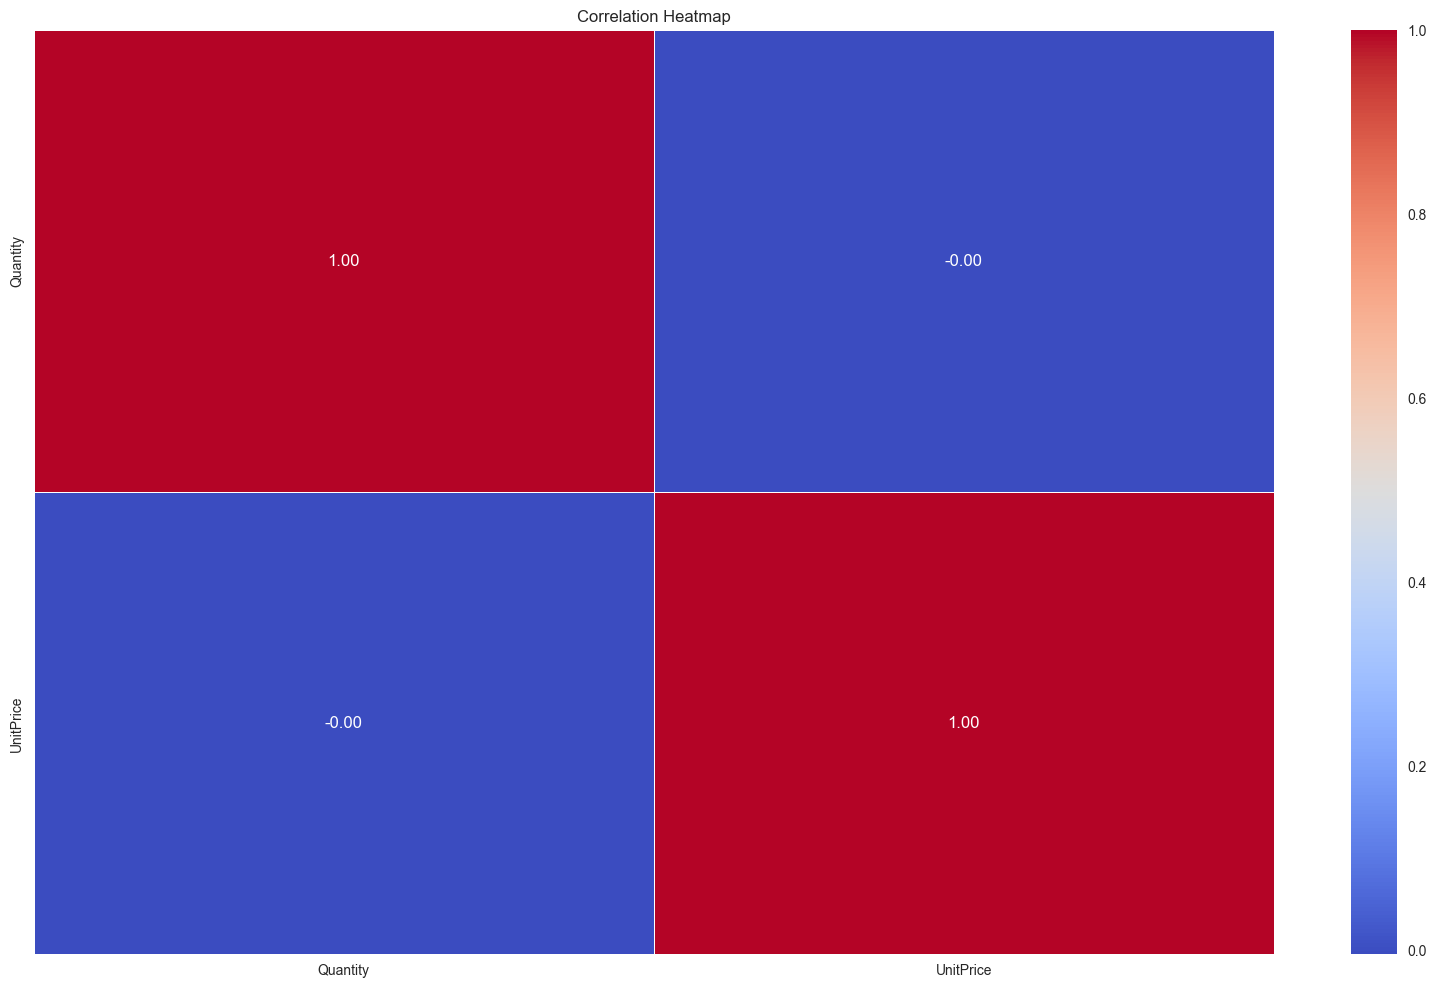

In [21]:
# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()
 
# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
 
#Save the image below
plt.savefig("Correlation Heatmap.png",dpi = 300,bbox_inches ="tight")

plt.show();

#### Countries Distribution

In [22]:
df2['Country'].value_counts()

Country
United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45


#### Region Distribution

In [23]:
# Mapping dictionary
country_to_region = {
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'France': 'Europe',
    'EIRE': 'Europe',
    'Spain': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Switzerland': 'Europe',
    'Portugal': 'Europe',
    'Australia': 'Oceania',
    'Norway': 'Europe',
    'Italy': 'Europe',
    'Channel Islands': 'Europe',
    'Finland': 'Europe',
    'Cyprus': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Denmark': 'Europe',
    'Poland': 'Europe',
    'Japan': 'Asia',
    'Israel': 'Asia',
    'Unspecified': 'Not specified',
    'Singapore': 'Asia',
    'Iceland': 'Europe',
    'USA': 'North America',
    'Canada': 'North America',
    'Greece': 'Europe',
    'Malta': 'Europe',
    'United Arab Emirates': 'Middle East',
    'European Community': 'Europe',
    'RSA': 'Africa',
    'Lebanon': 'Asia',
    'Lithuania': 'Europe',
    'Brazil': 'South America',
    'Czech Republic': 'Europe',
    'Bahrain': 'Middle East',
    'Saudi Arabia': 'Middle East'
}

# Create a new column 'Region' based on the mapping
df2['Region'] = df2['Country'].map(country_to_region)

# Display the DataFrame with the new column

df2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,Europe
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,Europe
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,Europe
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,Europe


In [24]:
region_counts = df2['Region'].value_counts()
region_counts

Region
Europe           395145
Oceania            1185
Asia                836
North America       330
Not specified       244
Middle East          94
Africa               58
South America        32
Name: count, dtype: int64

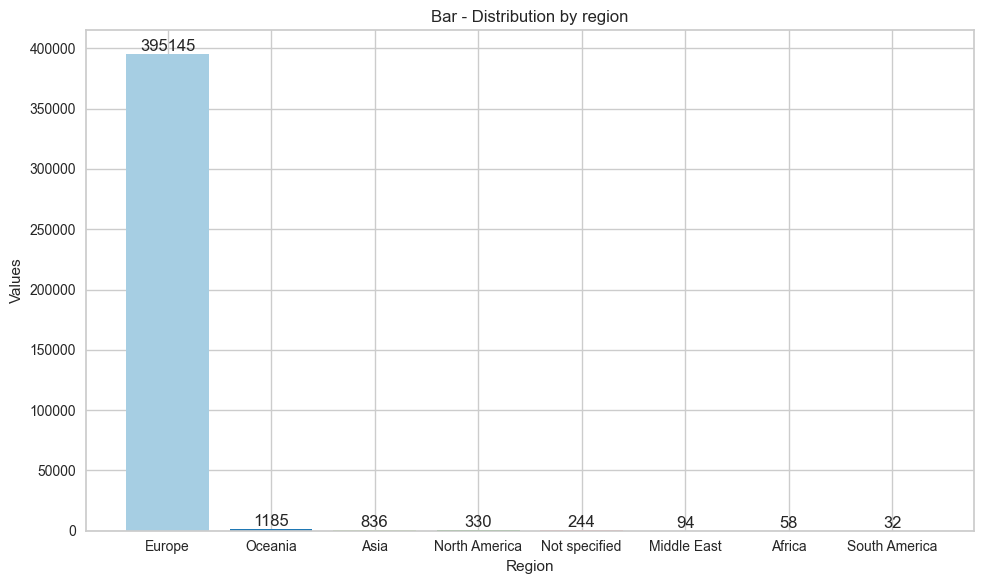

In [25]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(region_counts.index, region_counts.values, color=plt.cm.Paired(np.arange(len(region_counts))))

# Adding labels and title
plt.xlabel('Region')
plt.ylabel('Values')
plt.title('Bar - Distribution by region')

# Adding count values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [26]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe


In [27]:
df2['Sales_amount'] = df2['Quantity'] * df2['UnitPrice']

df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34


In [28]:
# Group merged_df by age
regions = df2.groupby('Region')
 
# Initialize a dictionary to store peak amounts by age
max_amount_by_region = {}
min_amount_by_region = {}
total_amount_by_region = {}
 
# Iterate over age groups to find peak amount for each age
for region, group_data in regions:
    max_amount = group_data['Sales_amount'].max()
    min_amount = group_data['Sales_amount'].min()
    total_amount = round(group_data['Sales_amount'].sum(),2)
    max_amount_by_region[region] = max_amount
    min_amount_by_region[region] = min_amount
    total_amount_by_region[region] = total_amount
 
# Convert the dictionary to a DataFrame for easier analysis (optional)
max_amount_by_region_df = pd.DataFrame(list(max_amount_by_region.items()), columns=['Region', 'Max_Amount'])
min_amount_by_region_df = pd.DataFrame(list(min_amount_by_region.items()), columns=['Region', 'Min_Amount'])
total_amount_by_region_df = pd.DataFrame(list(total_amount_by_region.items()), columns=['Region', 'Total_Amount'])
 
# Print or visualize the result
#print(max_amount_by_age_df min_amount_by_age_df)

min_max = max_amount_by_region_df.merge(min_amount_by_region_df, on='Region')
min_max_total = min_max.merge(total_amount_by_region_df, on='Region')
min_max_total

,Region,Max_Amount,Min_Amount,Total_Amount
0,Africa,38.25,0.00,1002.31
1,Asia,3949.32,0.29,67611.23
2,Europe,168469.60,0.00,8690619.01
3,Middle East,153.00,3.48,2596.60
4,North America,550.94,1.25,7246.77
5,Not specified,69.36,0.19,2667.07
6,Oceania,1718.40,0.00,138521.31
7,South America,175.20,15.00,1143.60


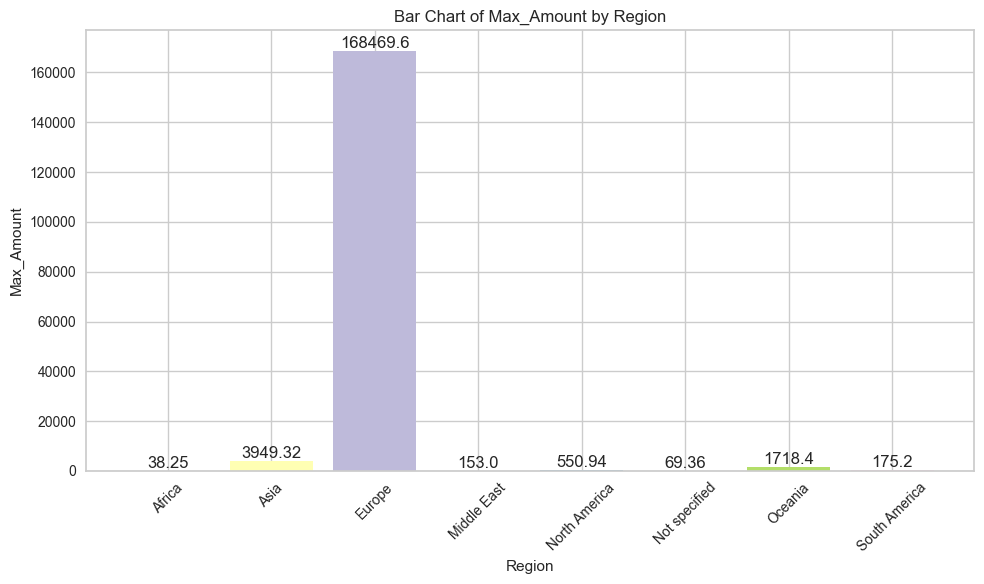

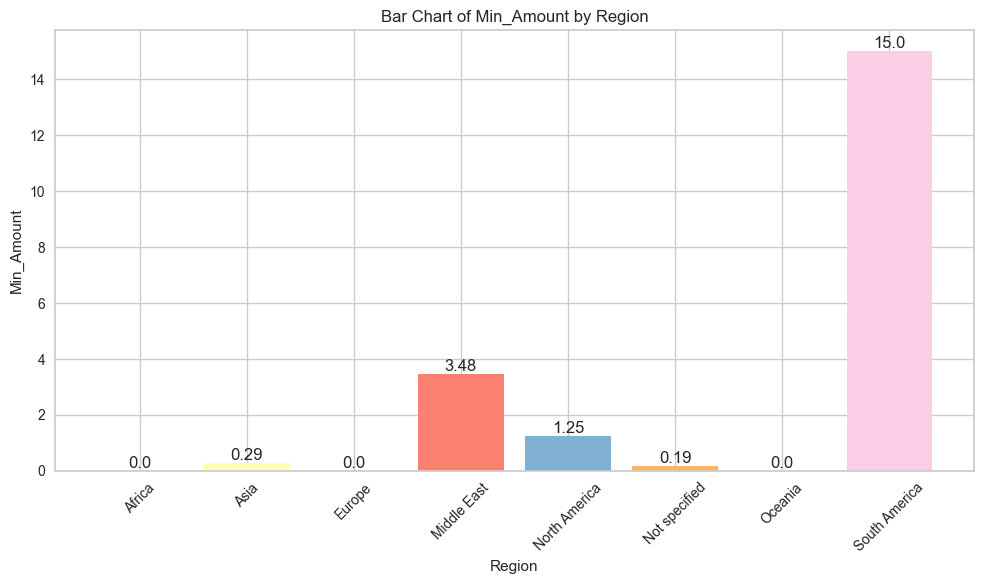

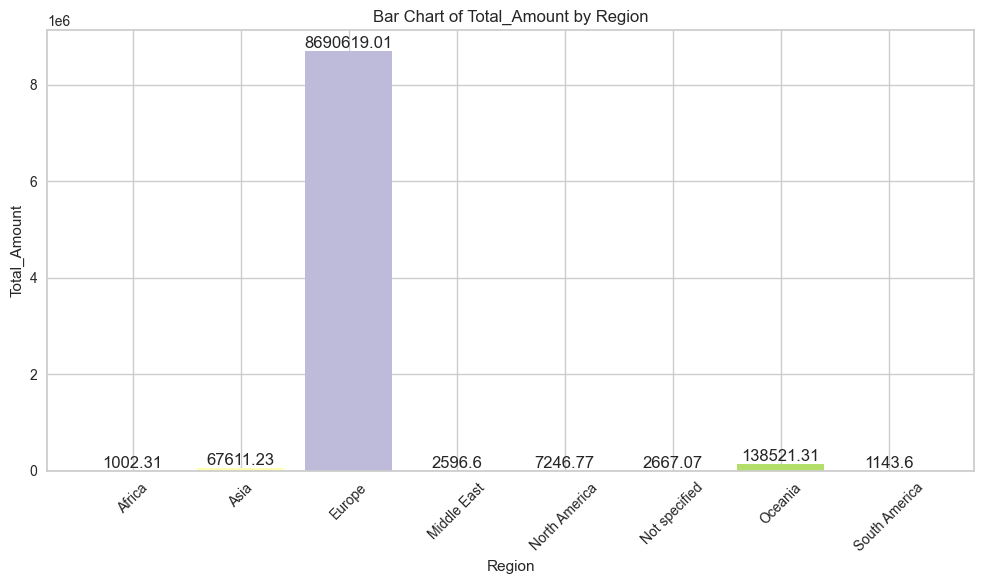

In [29]:
# Function to plot bar charts
def plot_bar_chart(column_name):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(min_max_total['Region'], min_max_total[column_name], color=sns.color_palette("Set3"))
    plt.xlabel('Region')
    plt.ylabel(column_name)
    plt.title(f'Bar Chart of {column_name} by Region')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Annotate each bar with its value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
    
    plt.tight_layout()
    plt.show()

# Plotting bar charts for each column
plot_bar_chart('Max_Amount')
plot_bar_chart('Min_Amount')
plot_bar_chart('Total_Amount')


#### Bar plot of total Sales Amount by country

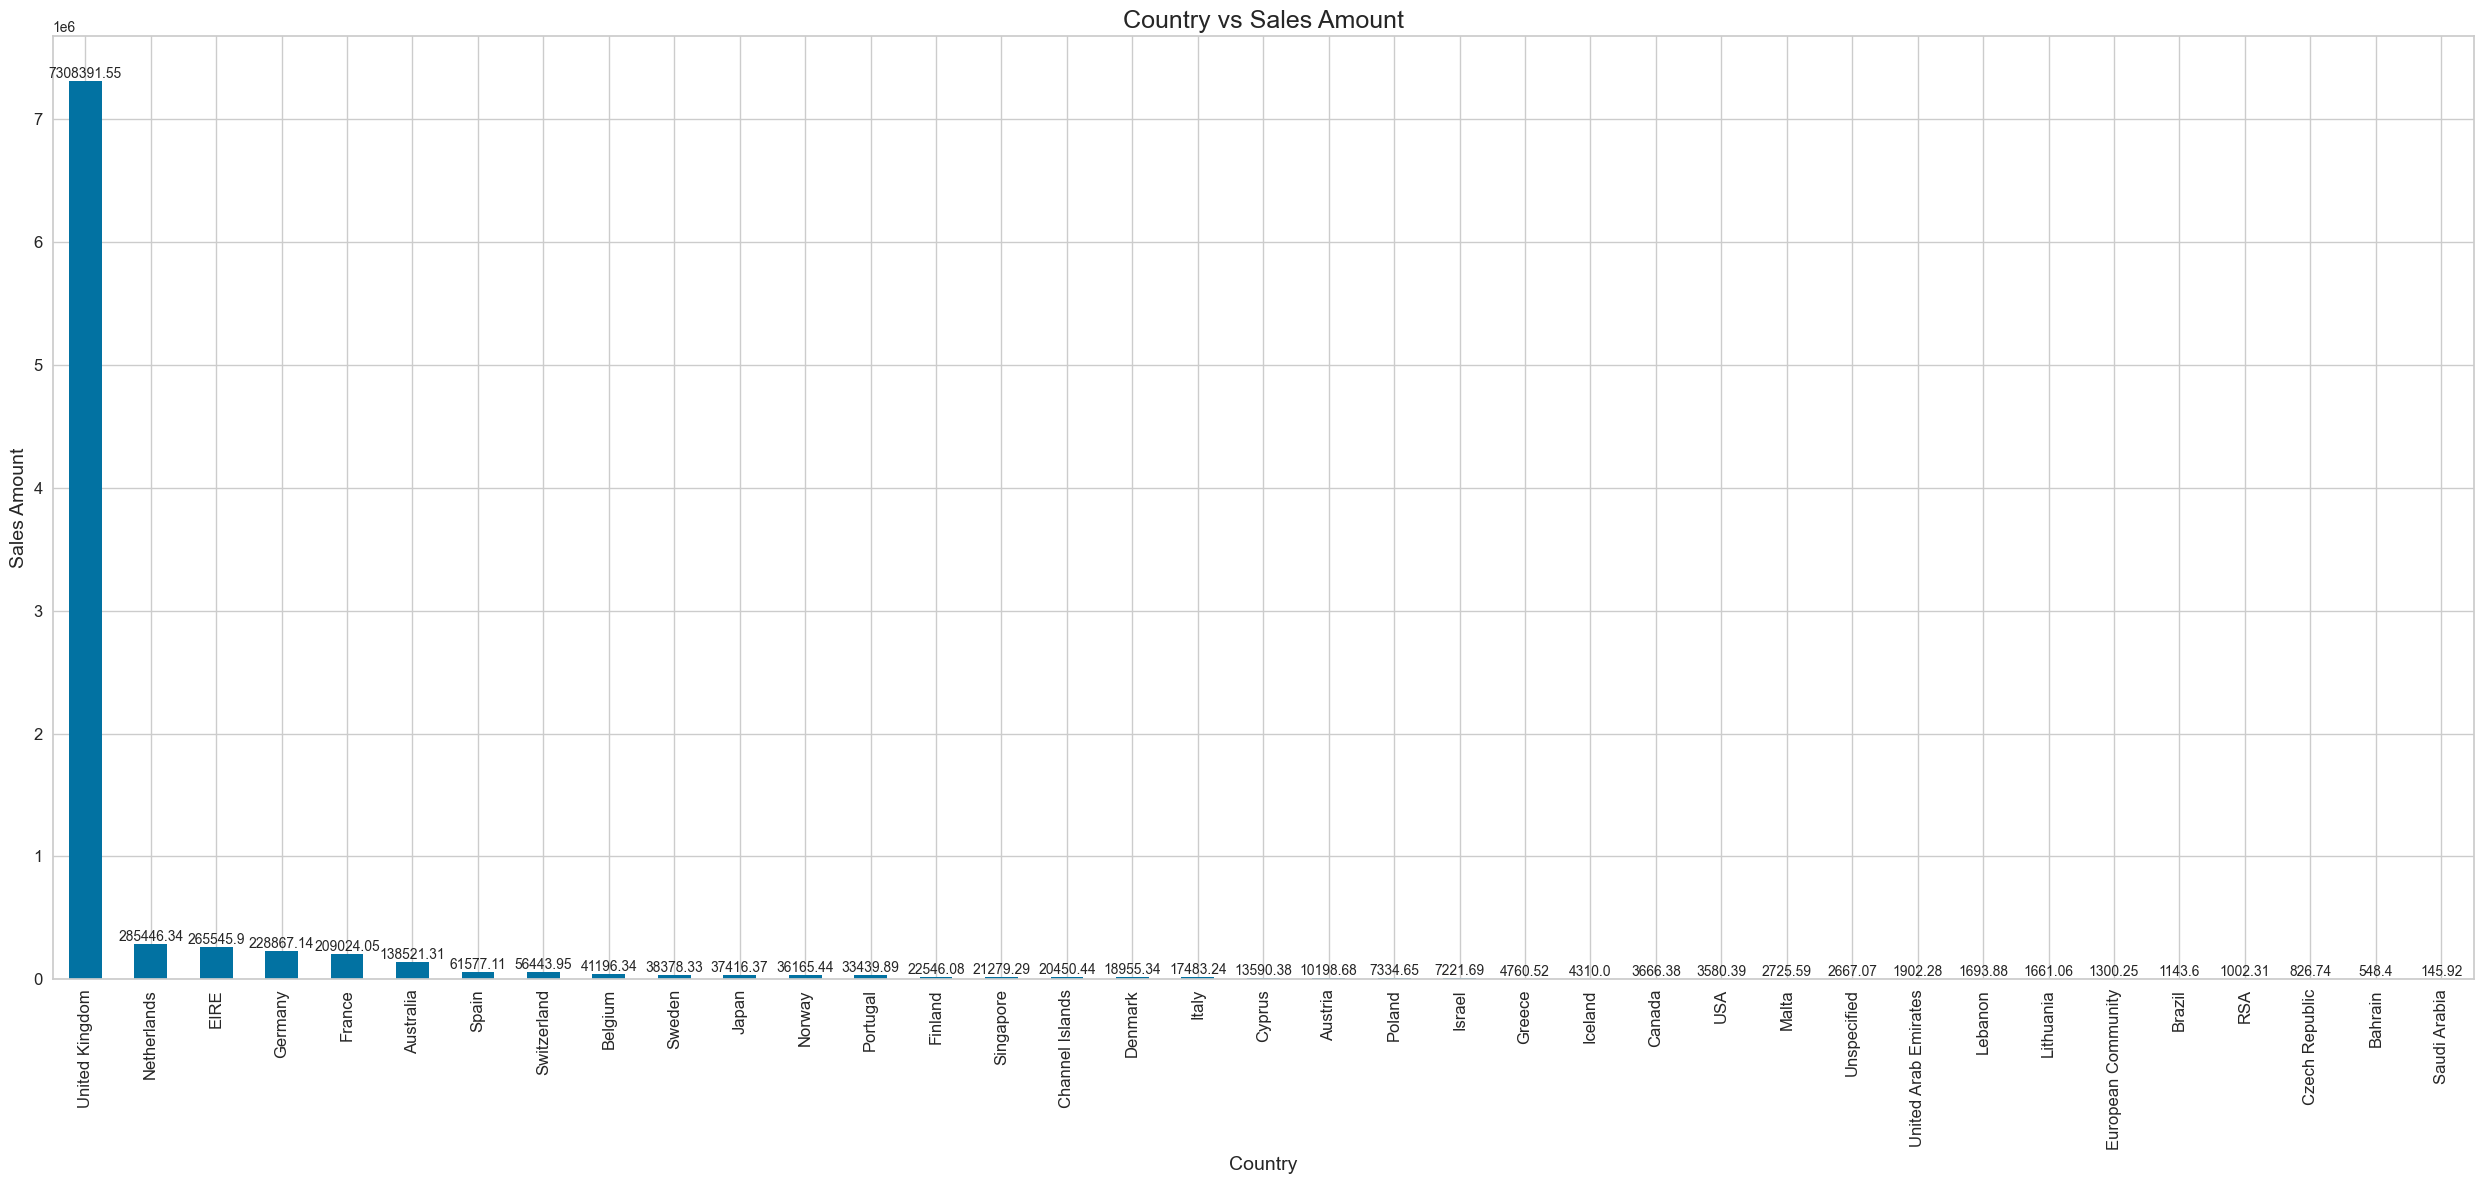

In [30]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(25, 12))

# Plotting the bar chart
bars = df2.groupby('Country')['Sales_amount'].sum().sort_values(ascending=False).plot.bar(ax=ax, fontsize=12)

# Adding labels and title
ax.set_title("Country vs Sales Amount", fontsize=18)
ax.set_xlabel("Country", fontsize=14)
ax.set_ylabel("Sales Amount", fontsize=14)

# Annotate each bar with its value
for bar in bars.patches:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 100, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


The bar graph illustrates the sales amounts for various countries, highlighting a significant disparity in sales distribution. The United Kingdom dominates with an overwhelming sales amount of 7,308,391.55, far exceeding any other country. The next highest sales amounts are for the Netherlands, EIRE, and Germany, each with sales between approximately 200,000 and 300,000. All other countries have considerably lower sales, with most not surpassing 100,000. This pronounced concentration of sales in the United Kingdom suggests a strong market presence or customer base there, while other countries contribute minimally to the overall sales. The graph underscores the United Kingdom's critical role in the sales landscape, with other countries playing a relatively minor role.

In [31]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Region,Sales_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,20.34


#### Movement of Sales Amount by All regions over time

In [35]:
# Extract month and year from 'InvoiceDate' and convert to string for plotting
df2['YearMonth'] = df2['InvoiceDate'].dt.strftime('%b\'%Y')  # Format like Jan'2011

# Group by 'Region' and 'YearMonth', summing 'Sales_amount'
region_monthly_sales = df2.groupby(['Region', 'YearMonth'])['Sales_amount'].sum().reset_index()

# Get unique regions
regions = region_monthly_sales['Region'].unique()

# Extract only 'YearMonth' values to ensure proper ordering
year_months = region_monthly_sales['YearMonth'].unique()

# Sort 'YearMonth' values chronologically (Dec'2010, Jan'2011, Feb'2011, etc.)
sorted_months = sorted(year_months, key=lambda x: pd.to_datetime(x, format='%b\'%Y'))

# Create a mapping dictionary to ensure proper order in Plotly
month_order = {month: idx for idx, month in enumerate(sorted_months)}

# Assign a numerical index to each 'YearMonth' based on the sorted order
region_monthly_sales['MonthIndex'] = region_monthly_sales['YearMonth'].map(month_order)

# Sort data by 'MonthIndex' to ensure it's plotted in ascending order
region_monthly_sales = region_monthly_sales.sort_values(by='MonthIndex')

# Plot using Plotly
fig = go.Figure()

# Colors for different regions
colors = ['green', 'blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, region in enumerate(regions):
    # Filter data for the current region
    data = region_monthly_sales[region_monthly_sales['Region'] == region]
    
    # Plot each region with a different color
    fig.add_trace(go.Scatter(x=data['YearMonth'], y=data['Sales_amount'],
                             mode='lines+markers',
                             name=region,
                             line=dict(color=colors[idx % len(colors)], width=2),  # Line color
                             marker=dict(color=colors[idx % len(colors)], size=8, line=dict(color='black', width=1)),  # Marker color with black borders
                             ))

# Customize layout
fig.update_layout(title='Sales Trend for All Regions',
                  title_font_color='white',  # Title font color
                  title_x=0.5,  # Title center alignment
                  xaxis_title='Month',
                  yaxis_title='Sales Amount',
                  xaxis=dict(tickangle=-45, categoryorder='array', categoryarray=sorted_months),  # Ensure x-axis is in correct order
                  plot_bgcolor='black',  # Black background
                  paper_bgcolor='black',  # Black background
                  font=dict(color='white'),  # White text color
                  legend=dict(font=dict(color='white')),  # White legend text color
                  )

fig.show()

The graph shows the sales trends across different regions from December 2010 to December 2011. Europe (in red) significantly outperforms all other regions, with a relatively consistent but slightly fluctuating trend and noticeable peaks in May 2011 and November 2011. The sales amounts for Africa, Asia, Middle East, North America, Oceania, and South America are minimal and appear almost flat, indicating negligible sales compared to Europe. This highlights that Europe is the dominant region in terms of sales, while the other regions contribute very little to the overall sales volume. The legend effectively distinguishes the different regions by color, aiding in the interpretation of the data.

#### Movement of Sales Amount by each regions over time

In [33]:
# Extract month and year from 'InvoiceDate' and convert to string for plotting
df2['YearMonth'] = df2['InvoiceDate'].dt.strftime('%b\'%Y')  # Format like Jan'2011

# Group by 'Region' and 'YearMonth', summing 'Sales_amount'
region_monthly_sales = df2.groupby(['Region', 'YearMonth'])['Sales_amount'].sum().reset_index()

# Get unique regions
regions = region_monthly_sales['Region'].unique()

# Creating interactive plots for each region
for region in regions:
    # Filter data for the current region
    data = region_monthly_sales[region_monthly_sales['Region'] == region]
    
    # Extract only 'YearMonth' values to ensure proper ordering
    year_months = data['YearMonth'].unique()
    
    # Sort 'YearMonth' values chronologically (Dec'2010, Jan'2011, Feb'2011, etc.)
    sorted_months = sorted(year_months, key=lambda x: pd.to_datetime(x, format='%b\'%Y'))
    
    # Create a mapping dictionary to ensure proper order in Plotly
    month_order = {month: idx for idx, month in enumerate(sorted_months)}
    
    # Assign a numerical index to each 'YearMonth' based on the sorted order
    data['MonthIndex'] = data['YearMonth'].map(month_order)
    
    # Sort data by 'MonthIndex' to ensure it's plotted in ascending order
    data = data.sort_values(by='MonthIndex')
    
    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['YearMonth'], y=data['Sales_amount'],
                             mode='lines+markers',
                             name=region,
                             line=dict(color='green', width=2),  # Green line
                             marker=dict(color='green', size=8, line=dict(color='black', width=1)),  # Green markers with black borders
                             ))
    
    # Customize layout
    fig.update_layout(title=f'Sales Trend for {region}',
                      title_font_color='white',  # Title font color
                      title_x=0.5,  # Title center alignment
                      xaxis_title='Month',
                      yaxis_title='Sales Amount',
                      xaxis=dict(tickangle=-45, categoryorder='array', categoryarray=sorted_months),  # Ensure x-axis is in correct order
                      plot_bgcolor='black',  # Black background
                      paper_bgcolor='black',  # Black background
                      font=dict(color='green'),  # Green text color
                      legend=dict(font=dict(color='green')),  # Green legend text color
                      )

    fig.show()
